In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from PIL import Image
from tqdm.notebook import tqdm
from tools.image_tools import train_model,get_columns, check_year
from tools.image_tools import *
from random import shuffle

# Columns

## Create data

In [20]:
import json
json_file_path = "/deezy_datadrive/kaspar-playground/page_segment/annotations/column_annotations_split.json"
json_file = json.load(open(json_file_path,'rb'))

from tools.image_tools import draw_polygons


draw_polygons(json_file,
                orig_path=Path("/deezy_datadrive/kaspar-playground/page_segment/to_annotate_columns"),
                out_path=Path("/deezy_datadrive/kaspar-playground/page_segment/columns"),
                codes={'page':0,'left_col':1,"right_col":2})


# Train model

In [32]:
target = 'columns'
path = Path(target)
root = Path("/deezy_datadrive/kaspar-playground/page_segment")
split_by_pct=.1
bs=1
wd=1e-2#1e-2
epochs=20
size=(750,750)


In [33]:
# learn = train_model(path,
#             root = root,
#             export_path= root / 'models'
# )

In [34]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

path_lbl = root /path/'labels'
path_img = root / path/'images'
codes = np.array(['page','left_col','right_col']) # 'column',

src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(split_by_pct)
        .label_from_func(get_y_fn, classes=codes))

data = (src.transform(size=size, tfm_y=True)  # (900,600)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

    
        

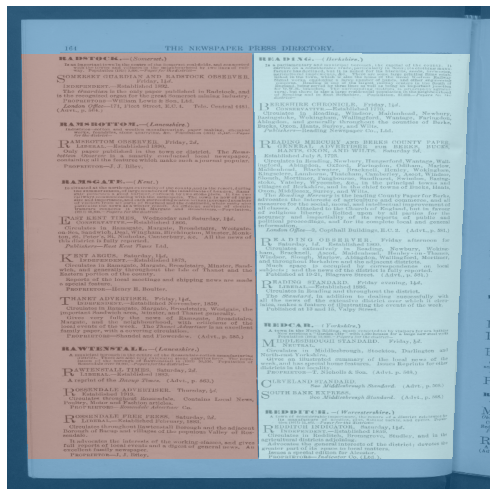

In [35]:
data.show_batch(2, figsize=(10,7))

In [37]:
def accuracy(input, target):
    """computes pixel level accuracy"""
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()


In [38]:
learn = unet_learner(data, 
                     models.resnet18, 
                     metrics=accuracy, 
                     wd=wd, 
                     bottle=True, 
                     self_attention=True, 
                     blur=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


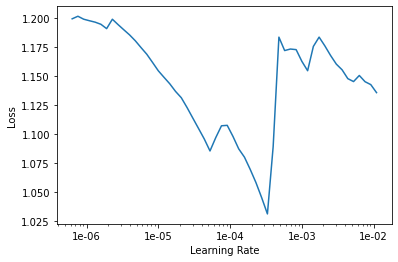

In [39]:

#learn.data = data
lr_find(learn)
learn.recorder.plot()


In [40]:
lr = 1e-4


In [41]:
#learn.fit_one_cycle(epochs, slice(lr), pct_start=0.8)
#learn.save(root / 'models'/ 'unet-stage-1')
#learn.load(root / 'models'/ 'unet-stage-1')

In [43]:
learn.unfreeze()
lrs = slice(lr/100,lr)
learn.fit_one_cycle(10, lrs, pct_start=0.9)

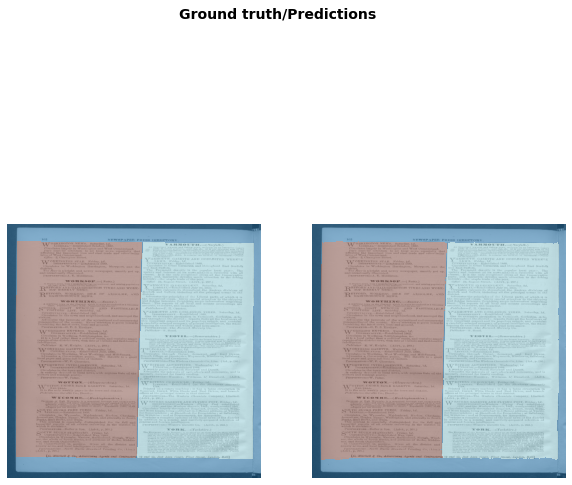

In [44]:
learn.show_results(2, figsize=(10,10))

In [45]:
export_path= root / 'models' / 'columns'
model_folder = Path(export_path)
model_folder.mkdir(exist_ok=True)
model_path = model_folder / 'export.pkl'
learn.export(model_path)

In [21]:
!ls {model_path}

/deezy_datadrive/kaspar-playground/page_segment/models/columns/export.pkl


# Load and apply model

In [ ]:
model_folder = Path('/deezy_datadrive/kaspar-playground/page_segment/models')
learn = load_learner(model_folder)

In [296]:

image_paths = list(Path("/deezy_datadrive/kaspar-playground/npd/Data/Original/").glob("**/Images/*.png"))
print(len(image_paths))
image_paths = [p for p in image_paths if check_year(p) >= 1855]
ignore_files = ['/deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1870/Images/MPD_1870_033.png',]
save_columns(image_paths, learn,ignore_files=ignore_files)

3767


/data/anaconda/envs/py37torch/lib/python3.7/site-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (110069584 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (110069584 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[WARNING] Error Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required. for file MPD_1870_033
[WARNING] Error Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required. for file MPD_1908_227



# Debug and inspect errors

In [20]:
image_paths = list(Path("/deezy_datadrive/kaspar-playground/npd/Data/Original/").glob("**/Images/*.png"))
image_paths = [p for p in image_paths if check_year(p) >= 1855]
p = image_paths[10]


In [106]:
#Image.open(image_path)
[(1439, 388),  (19, 4227), (56, 350)]
(1444, 4232),

Error type 2 /deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1895/Images/MPD_1895_087.png 56
Error type 2 /deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1864/Images/MPD_1864_102.png 387
Error type 2 /deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1864/Images/MPD_1864_113.png 444
Error type 2 /deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1878/Images/MPD_1878_125.png 150
Error type 2 /deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1878/Images/MPD_1878_110.png 152
Error type 2 /deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1891/Images/MPD_1891_082.png 655
Error type 2 /deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1870/Images/MPD_1870_032.png 926
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (110069584 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/data/anaconda/envs/py37torch/lib/python3.7/site-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (110069584 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
Error type 2 /deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1870/Images/MPD_1870_033.png 939

In [292]:
image_path = Path('/deezy_datadrive/kaspar-playground/npd/Data/Original/MPD_1895/Images/MPD_1895_070.png')
mask_arrayray = return_mask(image_path,learn)
l,r = get_columns(image_path,mask_array,buffer=25)

# Capitals

# Select and export for annotation

In [298]:
processed_image_paths = list(Path("/deezy_datadrive/kaspar-playground/npd/Data/Original/").glob("**/Image_processed/*.png"))
move_to = Path("/deezy_datadrive/kaspar-playground/page_segment/random_sample")
        
move_to.mkdir(exist_ok=True)
shuffle(processed_image_paths)
for p in processed_image_paths[:100]:
    shutil.move(p, move_to / p.name)


## Old scrips

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

In [ ]:
codes = array(['page','column','left_col','righ_col']) #array([target]*250 + ['page'] * 10)
len(codes)

In [ ]:
codes

In [ ]:
    free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
#bs=4

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       #.split_by_fname_file('../valid.txt')
       .split_by_rand_pct(.15)
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(size=(1100,1100), tfm_y=True)  # (900,600)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(50,70))

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id.get('Void',999)

def accuracy(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    
    #mask = mask.squeeze(1)
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=accuracy
wd=1e-2

In [ ]:
#??unet_learner

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=accuracy, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-5

In [ ]:
#learn.data = data

In [ ]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.8)

In [ ]:
#??learn.show_results

In [ ]:
learn.show_results(2, figsize=(100,75))

In [ ]:
model_folder = Path('/deezy_datadrive/kaspar-playground/page_segment/column_model')
model_folder.mkdir(exist_ok=True)
model_path = model_folder / 'export.pkl'
learn.export(model_path)

## Inference

In [ ]:
def return_mask(path,learn):
    # open image and predict pixel
    x = open_image(path)
    predictions = learn.predict(x)
    
    # open image with pillow
    image = Image.open(path)
    # convert to array
    image_array = np.array(image)
    height, width = image_array.shape
    
    # get the mask tenser
    mask = predictions[1]
    # remove dimension convert to uint8
    mask_image = Image.fromarray(np.array(mask.squeeze(0)).astype(np.uint8))
    # resize mask to size of the original image
    mask_image_resized = mask_image.resize((width,height))
    # convert resized mask to array
    mask_image_resized_array = np.array(mask_image_resized)
    
    return mask_image_resized_array

In [ ]:
def replace_after_last(row,code,replacement):
    locations = np.where(row==code)
    if len(locations[0]) > 0:
        last = locations[0][-1]
        row[last:] = replacement
    return row

def replace_before_first(row,code,replacement):
    locations = np.where(row==code)
    if len(locations[0]) > 0:
        first = locations[0][0]
        row[:first] = replacement
    return row

In [ ]:
def get_columns(mask_array,image_path,buffer=25):
    """get column based on mask
    replace some pixels
    """
#     def replace_after_last(row,code,replacement):
#         locations = np.where(row==code)
#         if len(locations[0]) > 0:
#             last = locations[0][-1]
#             row[min(last+buffer,len(row)):] = replacement
#             row[last:min(last+buffer,len(row))] = code
#         return row

#     def replace_before_first(row,code,replacement):
#         locations = np.where(row==code)
#         if len(locations[0]) > 0:
#             first = locations[0][0]
#             row[:max(0,first-buffer)] = replacement
#             row[max(0,first-buffer):] = code
#         return row
    
    mean_pixel_x = np.apply_along_axis(np.mean,0,mask_array)
    diff = np.diff(mean_pixel_x)
    split_middle = np.argmin(diff[1000:-1000])
    left_col_mask = mask_array[:,:1000+split_middle]
    right_col_mask = mask_array[:,1000+split_middle:]
    
    left_col_mask = np.apply_along_axis(replace_after_last,1,
                                        left_col_mask,
                                        code=2,
                                        replacement=0)
    
    left_col_mask[left_col_mask==3] = 2
    
    right_col_mask = np.apply_along_axis(replace_before_first,1,
                                         right_col_mask,
                                         code=3,
                                         replacement=0)
    right_col_mask[right_col_mask==2] = 3
    
    image_array = np.array(Image.open(image_path))
    
    left_col = image_array[:, :left_col_mask.shape[1]]
    right_col = image_array[:, -right_col_mask.shape[1]:]
    

    left_col[left_col_mask != 2] = 255 
    right_col[right_col_mask != 3] = 255 
    return left_col, right_col
    

In [ ]:
path ='./oos_pages/MPD_1875_125.png'
image_transformed = return_mask(path,learn)
l,r = get_columns(image_transformed,path)

In [ ]:
Image.fromarray(r)

In [ ]:
def get_chunk(position_array,max_gap_size=100):
    chunks = []
    gap = []
    i = 0
    chunk = []
    chunk.append(position_array[i])
    while i < len(position_array)-1:
        
        if (position_array[i+1] == position_array[i] + 1) and (not gap):
            print('1')
            chunk.append(position_array[i+1])
        
        elif (position_array[i+1] == position_array[i] + 1) and gap:
            print('2')
            chunk.extend(gap)
            chunk.append(position_array[i+1])
            gap = []
            
        elif len(gap) <= max_gap_size:
            gap.append(position_array[i+1])
        
        elif len(gap) > max_gap_size:
            chunks.append(chunk)
            gap = []
            chunk = []
        i+=1
    chunks.append(chunk)
    return chunks

In [ ]:
print('test')

In [ ]:
chunks

In [ ]:
def adjust_capitals(path,learn):
    """function that detects capitals, resizes them,
    and puts the resized capital back in the image
    """
    
    def get_offsets(pos_idx):
        """helper function that detects boundaries for capitals
        """
        i = 0
        # save coordinates
        caps = []
        # initialize empty image
        cap = []
    
        while i < len(pos_idx)-1:
            # if there is a gap of more than five pixel,
            # save existing coordinates, add them to caps
            # and open a new empty list
            if pos_idx[i+1] - pos_idx[i] > 5:
                caps.append(cap)
                cap = []
        
            else:
                # add new coordinate
                cap.append(pos_idx[i])
            i+=1
            # close existing cap at the end of the image
            if (i == len(pos_idx)-1) and cap:
                caps.append(cap)
        # get the first and last coordinates
        return [[min(c),max(c)] for c in caps]
    
    # open image and predict pixel
    x = open_image(path)
    predictions = learn.predict(x)
    
    # open image with pillow
    image = Image.open(path)
    # convert to array
    image_array = np.array(image)
    height, width = image_array.shape
    
    # get the mask tenser
    mask = predictions[1]
    # remove dimension convert to uint8
    mask_image = Image.fromarray(np.array(mask.squeeze(0)).astype(np.uint8))
    # resize mask to size of the original image
    mask_image_resized = mask_image.resize((width,height))
    # convert resized mask to array
    mask_image_resized_array = np.array(mask_image_resized)
    
    # compute sums of predicted scores along the height of the image
    height_sums = np.apply_along_axis(np.sum,1,mask_image_resized_array)
    # get capital boundaries alongs the height axis
    height_caps = get_offsets(np.where(height_sums > 0)[0])

    capitals = [] # save here coordinates and image as array 
    
    for y_b,y_e in height_caps:
        # get chunk defined by y_axis coordinates
        chunk = mask_image_resized_array[y_b:y_e,:]
        # compute the sum of predictions along the x axis
        width_sum = np.apply_along_axis(np.sum,0,chunk)
        # get offsets
        width_caps = get_offsets(np.where(width_sum > 0)[0])
        if len(width_caps) > 1:
            print('This should not happen')
            print(path)
        x_b,x_e = width_caps[0]
        # save image along with coordinates
        capitals.append((y_b,y_e,x_b,x_e,image_array[y_b:y_e,x_b:x_e]))
        
    
    for (y_b,y_e,x_b,x_e,cap) in capitals:
        try:
            # we resize the image by quartering it
            # divide size by two for both x and y
            y_res = abs(int((y_b - y_e) / 2))
            x_res = abs(int((x_b - x_e) / 2))
            # turn array back into image
            cap_img = Image.fromarray(cap)
            # resize
            cap_img_res = cap_img.resize((x_res,y_res))
            # turn image back into array
            cap_img_res_arr = np.array(cap_img_res).copy()
            # the hook is the point that determins where
            # we will put the resized capital matrix
            hook_y = y_b
            hook_x = x_b + x_res
            # erase original capital with white space
            image_array[y_b:y_e-5,x_b:x_e-5] = 255
            # insert resized capital
            image_array[hook_y: hook_y + y_res,
                             hook_x: hook_x + x_res] = cap_img_res_arr
        except Exception as e:
            print("Other error:")
            print(e)
            print(path)
    
    return Image.fromarray(image_array)


In [ ]:
# path = "./Processed_images/MPD_1885/MPD_1885_062_right.png"
# return_inferred(path,learn) #cap_learner

In [ ]:
path = "./Processed_images/MPD_1885/MPD_1885_062_right.png"
#cap_learner = learn.load('capital_detect.pt')
adjust_capitals(path,learn) #cap_learner

In [ ]:
get_year = lambda p: int(p.stem.split("_")[1])
images_path = Path("./Processed_images/")
images = list(images_path.glob("**/*.png"))
out_path = Path("./Processed_images_adj_capitals/")
out_path.mkdir(exist_ok=True)
for img in tqdm(images):
    folder = img.parent.name
    (out_path / folder).mkdir(exist_ok=True)
    move_to = out_path / folder / "Images_processed" 
    move_to.mkdir(exist_ok=True)
    out_image_path = move_to / img.name
    if out_image_path.is_file():continue
    if get_year(img) < 1860:
         shutil.copy(img,out_image_path)
    else:
        img_transformed = adjust_capitals(img,learn)
        img_transformed.save(out_image_path)

In [ ]:
images = list(out_path.glob("**/*.png"))
image = Image.open(images[110])
image

In [ ]:
!ls Processed_images_wo_capitals/

In [ ]:
#scp -r Processed_images_wo_capitals/* kaspar@52.148.215.38:/data/tesstutorial/images

#### 